In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
from datetime import datetime
from math import sqrt
from pmdarima import auto_arima
from scipy import signal
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

df = pd.read_csv(r'C:\Users\jtrie\OneDrive\WGU\D213\Task1\teleco_time_series .csv')

df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [129]:
# Check for missing values
df.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [130]:
df.isna().sum()

Day        0
Revenue    0
dtype: int64

In [131]:
# Check for duplicated values within the dataset
print(df.duplicated().value_counts())

False    731
Name: count, dtype: int64


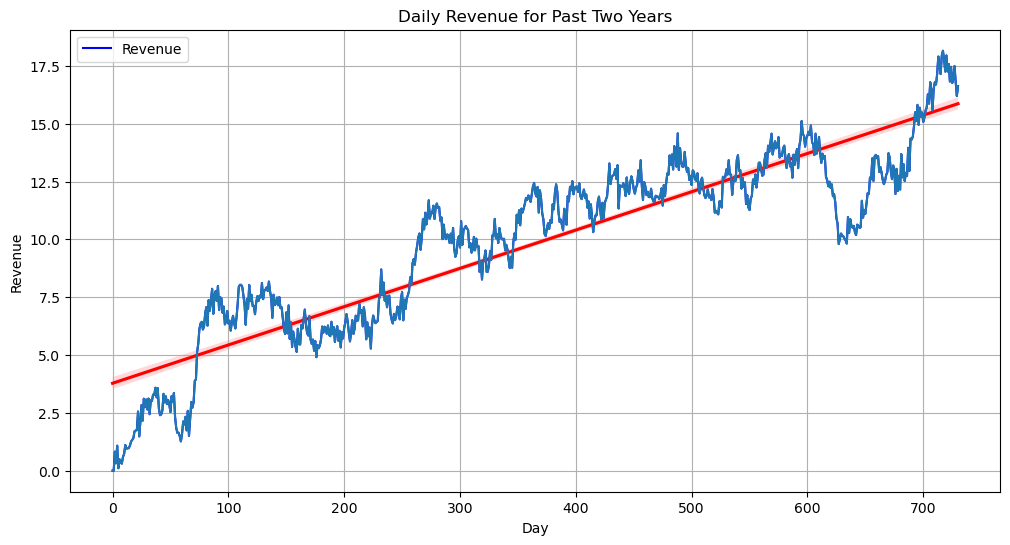

In [132]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Revenue'], label='Revenue', color='blue')
sns.regplot(x=pd.to_numeric(df.index), y=df['Revenue'], scatter=False, color='red', label='Trend Line')
plt.plot(df['Revenue'])
plt.title('Daily Revenue for Past Two Years')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

### Our observed data is showing a positive trend over time
<br>

In [133]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Num of Lags:', result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

print("\nStationarity Evaluation (ADF Test):")
adf_test(df['Revenue'])


Stationarity Evaluation (ADF Test):
ADF Statistic: -1.924612157310183
p-value: 0.3205728150793967
Num of Lags: 1
Critical Values:
   1%: -3.4393520240470554
   5%: -2.8655128165959236
   10%: -2.5688855736949163


### Since the p-value of the eval above is greater than 0.05, the data is non-stationary and needs differencing. This also indicates that our 'd' value for ARIMA would likely be > 0.
<br>

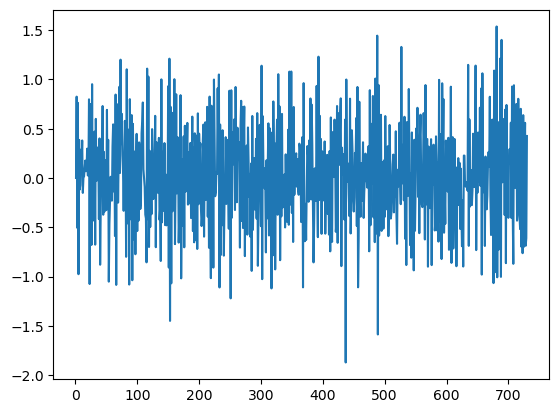

In [134]:
# Difference and visualize the data to help comfirm stationarity
data_diff = df.diff().dropna()
plt.plot(data_diff['Revenue'])

In [135]:
# Runa an ADF test again just to confirm stationarity
adf_test(data_diff['Revenue'])

ADF Statistic: -44.87452719387599
p-value: 0.0
Num of Lags: 0
Critical Values:
   1%: -3.4393520240470554
   5%: -2.8655128165959236
   10%: -2.5688855736949163


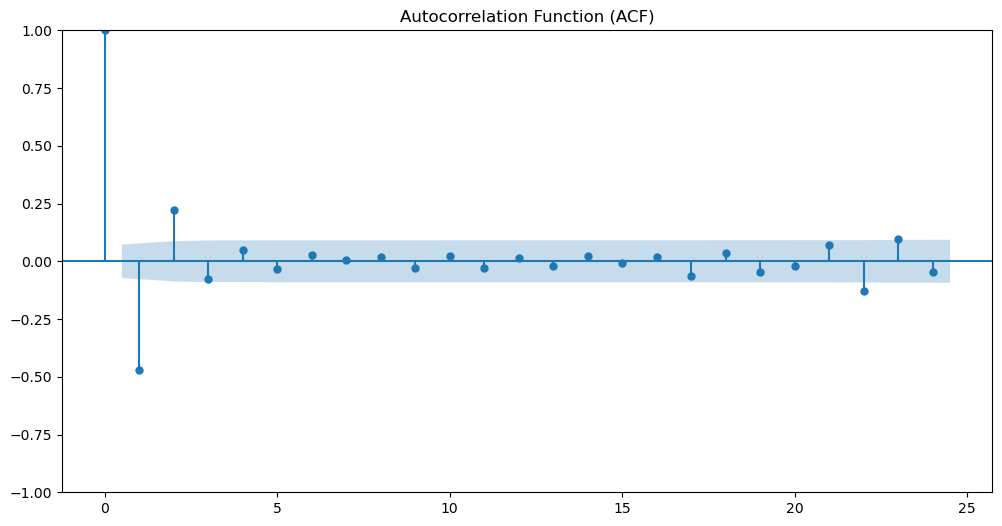

In [136]:
# ACF Plot with diff data
plt.figure(figsize=(12, 6))
plot_acf(data_diff['Revenue'], lags=24, ax=plt.gca())  # lags is the number of lags to show
plt.title('Autocorrelation Function (ACF)')
plt.show()

### We can see in this graph that the largest spike occurs with the first lag. It is also outside of the confidence interval (shaded area). This goes to show our 'q' value for ARIMA is most likely 1.
<br>

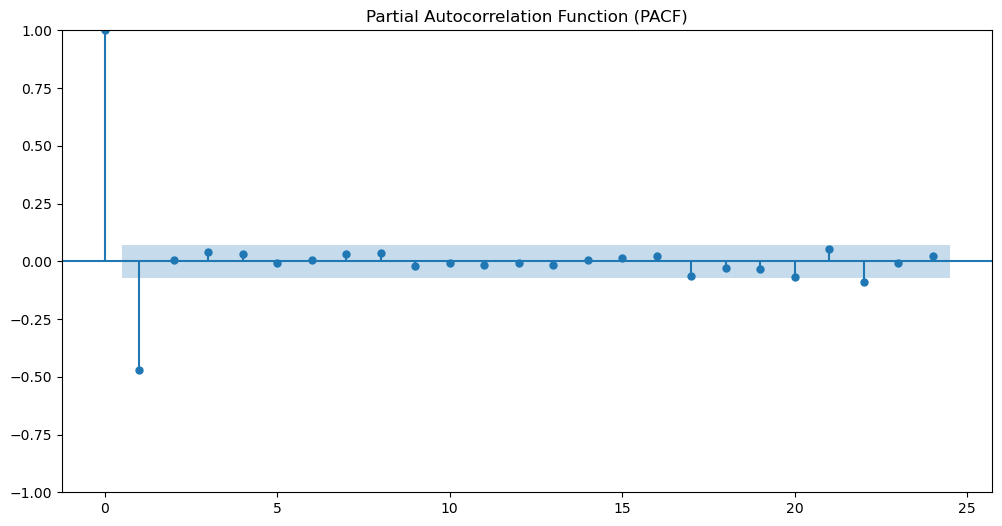

In [137]:
# PACF Plot with diff data
plt.figure(figsize=(12, 6))
plot_pacf(data_diff['Revenue'], lags=24, ax=plt.gca(), method='ywm') # method is optional, but recommended
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

### We can see in this graph that the largest spike occurs with the first lag. It is also outside of the confidence interval (shaded area). The second spike also falls pretty far outside the confidence interval. This goes to show our 'p' value for ARIMA is most likely 1, but could possibly be 2.
<br>

### P-value is now less than 0.05. Data is stationary.
<br>

In [138]:
start_date = datetime(2023, 1, 1)

# Convert 'Day' to timedelta
day_deltas = pd.to_timedelta(df['Day'] - df['Day'].min(), unit='d')

# Add timedelta to the starting date
df['Date'] = start_date + day_deltas
data_diff['Date'] = start_date + day_deltas
# Print the DataFrame with the new 'Date' column
print(df)

     Day    Revenue       Date
0      1   0.000000 2023-01-01
1      2   0.000793 2023-01-02
2      3   0.825542 2023-01-03
3      4   0.320332 2023-01-04
4      5   1.082554 2023-01-05
..   ...        ...        ...
726  727  16.931559 2024-12-27
727  728  17.490666 2024-12-28
728  729  16.803638 2024-12-29
729  730  16.194813 2024-12-30
730  731  16.620798 2024-12-31

[731 rows x 3 columns]


In [139]:
df.set_index('Date', inplace=True)
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=731, freq=None)

In [140]:
data_diff.set_index('Date', inplace=True)
data_diff.index

DatetimeIndex(['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09',
               '2023-01-10', '2023-01-11',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=730, freq=None)

In [141]:
#train_size = int(len(df) * 0.8)
train = df.iloc[:-90]
test = df.iloc[-90:]
print(train.shape, test.shape)

(641, 2) (90, 2)


In [142]:
#train_size = int(len(df) * 0.8)
train_diff = data_diff.iloc[:-90]
test_diff = data_diff.iloc[-90:]
print(train.shape, test.shape)

(641, 2) (90, 2)


In [143]:
#train_diff.to_csv(r'C:\Users\jtrie\OneDrive\WGU\D213\Task1\df_train_task1.csv', index=False, header=True)
#test_diff.to_csv(r'C:\Users\jtrie\OneDrive\WGU\D213\Task1\df_test_task1.csv', index=False, header=True)

<Axes: xlabel='Date'>

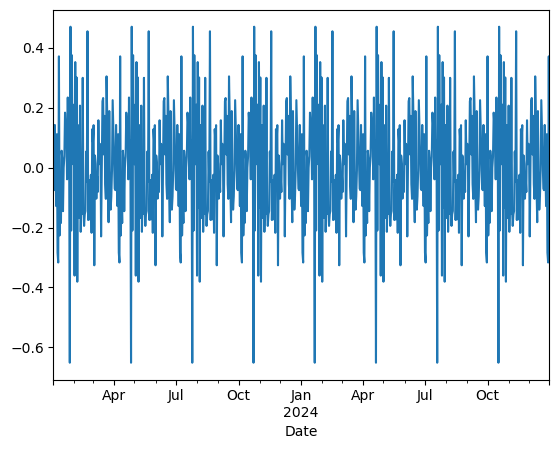

In [144]:
decomposition = seasonal_decompose(data_diff['Revenue'], model='additive', period=90) #adjust period as needed
decomposition.seasonal.plot()

### From our decomposition, with period set to 24 (for 24 months), we can see there is a definite seasonality to our data. 
<br>

<Axes: xlabel='Date'>

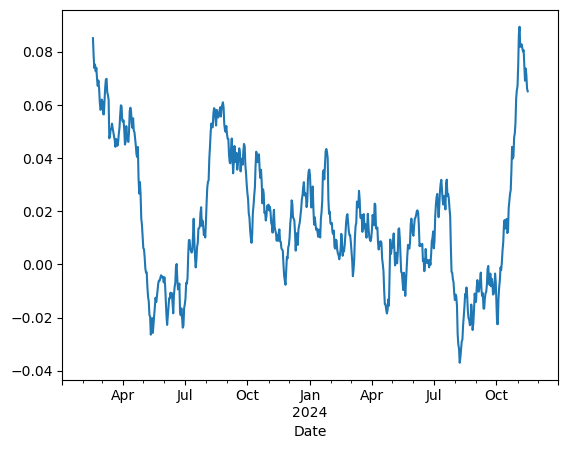

In [145]:
decomposition.trend.plot()

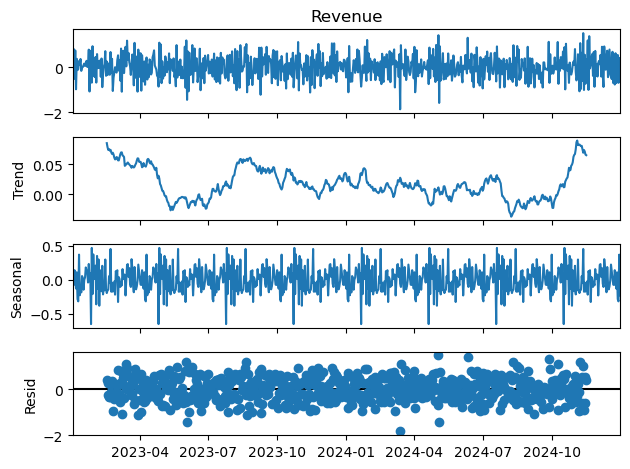

In [146]:
decomposition.plot()
plt.show()

<Axes: xlabel='Date'>

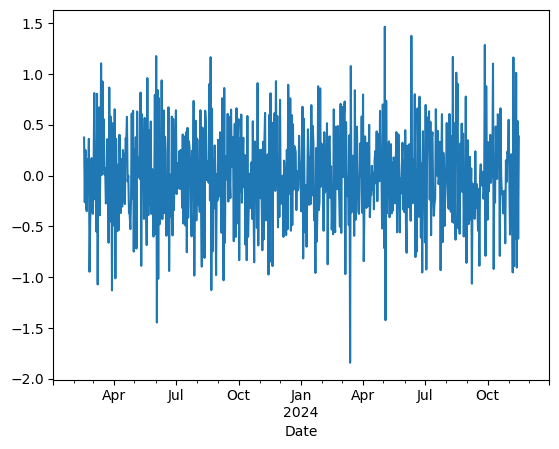

In [147]:
decomposition.resid.plot()

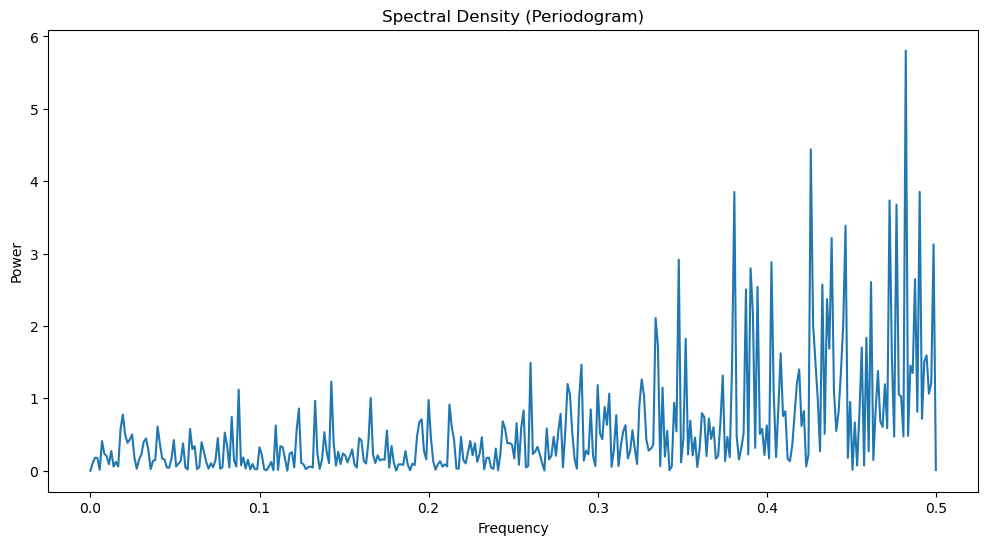

In [148]:
frequencies, power_spectrum = signal.periodogram(data_diff['Revenue'].dropna()) #drop nan values before periodogram.
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Spectral Density (Periodogram)')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [149]:
autoModel = auto_arima(train['Revenue'], seasonal = True, m=1, trace=True, suppress_warnings=True)
autoModel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=851.096, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=992.906, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=847.028, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=875.628, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=991.543, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=848.980, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=848.989, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=850.280, Time=0.86 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=846.716, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=848.637, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=848.653, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=875.578, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=849.696, Time=0.36 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.002 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  641
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -421.358
Date:                Sat, 29 Mar 2025   AIC                            846.716
Time:                        11:15:32   BIC                            855.639
Sample:                    01-01-2023   HQIC                           850.180
                         - 10-02-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4524      0.035    -12.962      0.000      -0.521      -0.384
sigma2         0.2184      0.013     16.662      0.000       0.193       0.244
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.97   Prob(JB):                         0.39
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Running Auto ARIMA helps narrow down what the best order for our ARIMA model will be. The order with the lowest AIC (847.023) is ( 1, 1, 0) 
<br>

In [150]:
model = ARIMA(train['Revenue'], order = (1, 1, 0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  641
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -421.358
Date:                Sat, 29 Mar 2025   AIC                            846.716
Time:                        11:15:32   BIC                            855.639
Sample:                    01-01-2023   HQIC                           850.180
                         - 10-02-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4524      0.035    -12.962      0.000      -0.521      -0.384
sigma2         0.2184      0.013     16.662      0.000       0.193       0.244
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.97   Prob(JB):                         0.39
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
model = ARIMA(train['Revenue'], order = (1, 0, 0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  641
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -496.652
Date:                Sat, 29 Mar 2025   AIC                            999.304
Time:                        11:15:32   BIC                           1012.693
Sample:                    01-01-2023   HQIC                          1004.501
                         - 10-02-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0768      1.871      4.317      0.000       4.410      11.744
ar.L1          0.9923      0.004    225.406      0.000       0.984       1.001
sigma2         0.2740      0.016     16.803      0.000       0.242       0.306
===================================================================================
Ljung-Box (L1) (Q):                 131.89   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.00   Prob(JB):                         0.37
Heteroskedasticity (H):               0.95   Skew:                            -0.08
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
model = ARIMA(train['Revenue'], order = (1, 1, 1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  641
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -421.326
Date:                Sat, 29 Mar 2025   AIC                            848.653
Time:                        11:15:32   BIC                            862.037
Sample:                    01-01-2023   HQIC                           853.848
                         - 10-02-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4681      0.075     -6.252      0.000      -0.615      -0.321
ma.L1          0.0197      0.083      0.236      0.813      -0.144       0.183
sigma2         0.2184      0.013     16.650      0.000       0.193       0.244
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.94   Prob(JB):                         0.39
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### After running ARIMA models with different orders than (1, 1, 0), I can confirm it has the lowest AIC and we will use that order to create our model with.
<br>

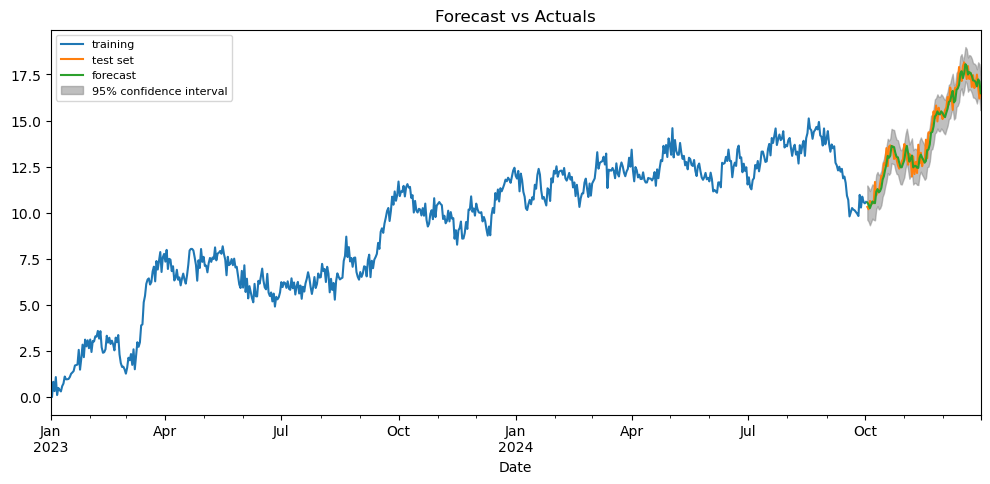

In [166]:
mod = ARIMA(df['Revenue'], order = (1, 1, 0))
model = mod.fit()

# Plot using plot_predict
fig, ax = plt.subplots(figsize=(12, 5))
train['Revenue'].plot(ax=ax, label='training')
test['Revenue'].plot(ax=ax, label='test set')

plot_predict(model, start=len(train), end=len(train) + len(test) -1, ax=ax, plot_insample=False, alpha=0.05)

ax.set_title('Forecast vs Actuals')
ax.legend(loc='upper left', fontsize=8)
plt.show()

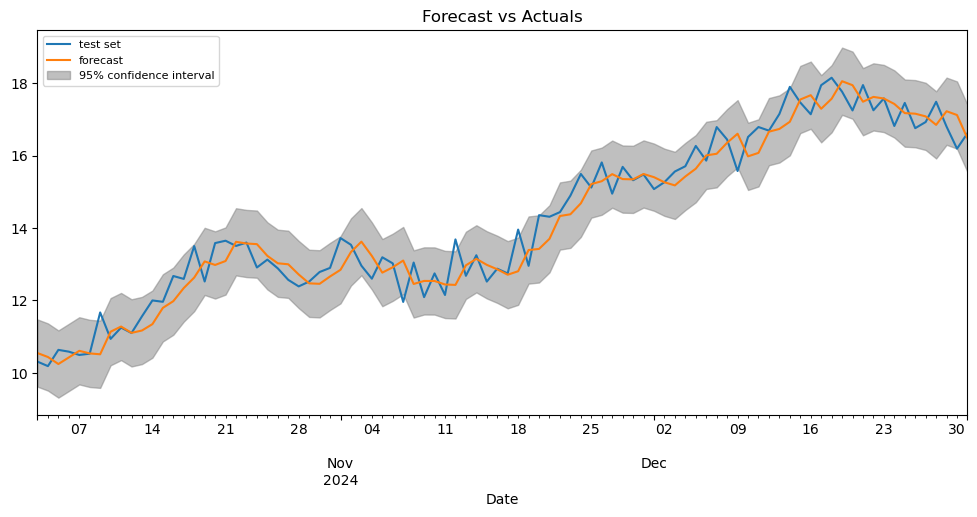

In [154]:
# Plot using plot_predict
fig, ax = plt.subplots(figsize=(12, 5))
test['Revenue'].plot(ax=ax, label='test set')

plot_predict(model, start=len(train), end=len(train) + len(test) -1, ax=ax, plot_insample=False, alpha=0.05)

ax.set_title('Forecast vs Actuals')
ax.legend(loc='upper left', fontsize=8)
plt.show()

In [155]:
forecast = model.forecast(steps=len(test))
forecast = forecast[:len(test)]
test_revenue = test['Revenue'][:len(forecast)]

rmse = np.sqrt(mean_squared_error(test_revenue, forecast ))
print(f"RMSE: {rmse}")

RMSE: 3.1369377385946478


### The model built off our training data was able to create a forecast that is quite tight with our test data. The RMSE of the model is even showing it's quite reliable. The RMSE was 3.14.
<br>

In [162]:
forecast = model.get_prediction(start = 730, end = 820, dynamic = True)
forecast.predicted_mean

2024-12-31    16.478925
2025-01-01    16.346343
2025-01-02    16.408213
2025-01-03    16.379341
2025-01-04    16.392814
                ...    
2025-03-27    16.388527
2025-03-28    16.388527
2025-03-29    16.388527
2025-03-30    16.388527
2025-03-31    16.388527
Freq: D, Name: predicted_mean, Length: 91, dtype: float64

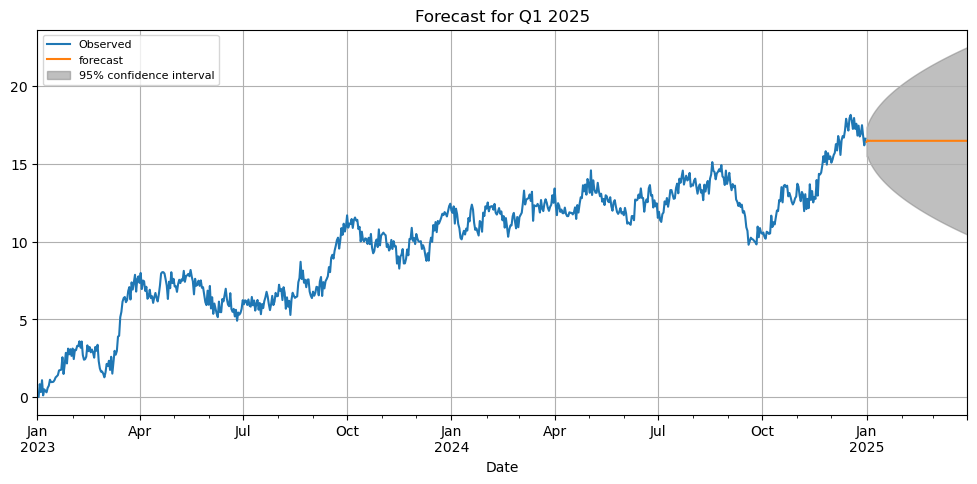

In [168]:
model = ARIMA(df['Revenue'], order = (1,1,0))
model = model.fit()

# Out-of-sample forecast for 90 days
forecast_steps = 90
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps, freq=df.index.freq) #create index for forecast

# Plot using plot_predict
fig, ax = plt.subplots(figsize=(12, 5))
df['Revenue'].plot(ax=ax, label='Observed')

plot_predict(model, start=len(df), end=len(df) + forecast_steps - 1, ax=ax, plot_insample=False, alpha=0.05)

ax.set_title('Forecast for Q1 2025')
ax.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

### The graph and predicted mean of our model show that we should expect an average of 16.39 million over quarter 1 of 2025. Looking at the volatility of the previous two quarters and the range of the confidence intervals in the graph, the actual average could potentially be higher or lower by about 6 million dollars.
<br>

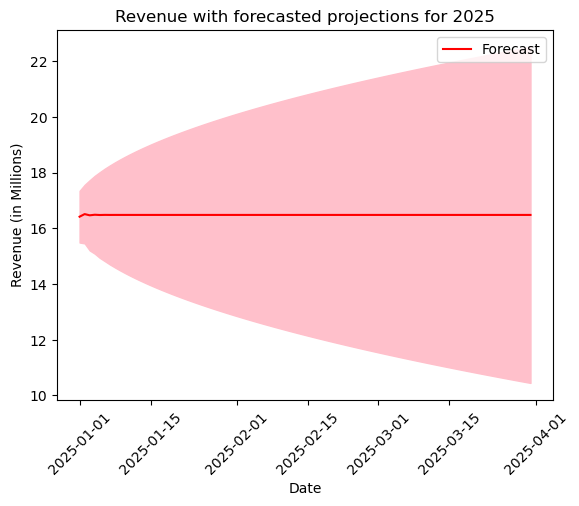

In [169]:
mod = ARIMA(df['Revenue'], order = (1, 1, 0))
model = mod.fit()

diff_forecast = model.get_forecast(steps=90)
mean_forecast = diff_forecast.predicted_mean
# print(mean_forecast.head(5))

# Get confidence intervals of predictions
confidence_intervals = diff_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower Revenue']
upper_limits = confidence_intervals.loc[:, 'upper Revenue']

# Plot the forecasted revenue data
#plt.plot(df.index, df, label='Observed')

# Plot the mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')

# Shade the area between the confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.title('Revenue with forecasted projections for 2025')
plt.xlabel('Date')
plt.ylabel('Revenue (in Millions)')
plt.xticks(rotation=45)
plt.legend()
plt.show()